# Исследование тарифов для телеком компании

Заказчик: федеральный оператор сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». 

Цель: для корректировки рекламного бюджета определить какой тариф приносит больше денег.

Задача: проанализировать поведение клиентов и определить лучший тариф.

Данные: данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. 

Описание тарифов

**Тариф «Смарт»**

Ежемесячная плата: 550 рублей

Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика

Стоимость услуг сверх тарифного пакета:

- минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.)
- сообщение: 3 рубля
- 1 Гб интернет-трафика: 200 рублей

**Тариф «Ультра»**

Ежемесячная плата: 1950 рублей

Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика

Стоимость услуг сверх тарифного пакета:

- минута разговора: 1 рубль
- сообщение: 1 рубль
- 1 Гб интернет-трафика: 150 рублей

# Оглавление <a id="0"></a>

1. [Описание данных](#1)

    
2. [Открытие и изучение данных](#2)

   
3. [Предобработка данных](#3)

    3.1 [calls](#3_1)

    3.2 [internet](#3_2)

    3.3 [messages](#3_3)
    
    3.4 [tariffs](#3_4)
    
    3.5 [users](#3_5)
    
    3.6 [Изменение типа данных (даты) по всем таблицам](#3_6)
    
    3.7 [Расчет месячных показателей для каждого пользователя](#3_7)
    
    3.8 [Расчет месячной выручки с каждого пользователя](#3_8)  
   
    
4. [Анализ данных](#4)

    4.1 [Минуты](#4_1)
        
    4.2 [СМС](#4_2)
    
    
5. [Проверка гипотез](#5)

    5.1 [средняя выручка пользователей тарифов "Ультра" и "Смарт"](#5_1)
        
    5.2 [средняя выручка пользователей из Москвы и регионов](#5_2)
    
    5.3 [средняя выручка пользователей из Москвы и регионов для тарифа "Ультра"](#5_3)
    
    5.4 [средняя выручка пользователей из Москвы и регионов для тарифа "Смарт"](#5_4)
    
   
6.[Общий вывод](#6)

# Обзор и первичное исследование данных

Описание данных <a id="1"></a>

Таблица users (информация о пользователях):
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

Таблица calls (информация о звонках):
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

Таблица messages (информация о сообщениях):
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

Таблица internet (информация об интернет-сессиях):
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

Таблица tariffs (информация о тарифах):
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Открытие и изучение данных <a id="2"></a>

In [1]:
import pandas as pd
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt 
from math import factorial
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')
import datetime as dt
import math

In [2]:
calls = pd.read_csv('https://.../calls.csv')
internet = pd.read_csv('https://.../internet.csv')
messages = pd.read_csv('https://.../messages.csv')
tariffs = pd.read_csv('https://.../tariffs.csv')
users = pd.read_csv('https://.../users.csv')

## Предобработка данных <a id="3"></a>

Сначала рассмотрим каждую таблицу отдельно.

### calls <a id="3_1"></a>

In [3]:
calls.sample(5, random_state=42)

,id,call_date,duration,user_id
158741,1392_406,2018-07-09,4.94,1392
95947,1244_202,2018-11-09,0.00,1244
10624,1027_494,2018-10-07,3.10,1027
167423,1412_340,2018-09-25,5.91,1412
73194,1184_168,2018-09-03,9.86,1184


In [4]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Так как у нас всего один количественный показатель - длительность звонков в минутах, то статистически показатели выведем только по нему, а сразу посмотрим на распределение. 

In [5]:
calls['duration'].describe()

count    202607.000000
mean          6.755887
std           5.843365
min           0.000000
25%           1.300000
50%           6.000000
75%          10.700000
max          38.000000
Name: duration, dtype: float64

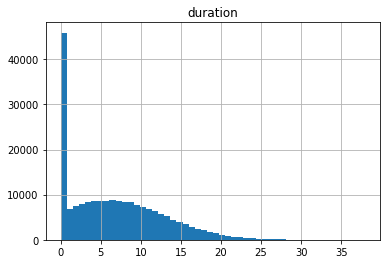

In [6]:
calls.hist('duration', bins=50)
plt.show()

In [7]:
print ('Количество звонков с нулевой длительностью:', len(calls.query('duration == 0')), 
       ', доля в общем количестве:', round((len(calls.query('duration == 0'))/len(calls['duration'])), 2))


Количество звонков с нулевой длительностью: 39613 , доля в общем количестве: 0.2


"Мегалайн" округляет вверх значения минут, даже если проговорили 1 секунду. Стоимость за минуту разговора в случае использования сверх тарифа: 3 рубля для Смарта и 1 рубль для Ультры.

Доля звонков с нулевой продолжительностью - 20 % от общего количества звонков. Маловероятно, что это ошибка, скорее всего пропущенные/непринятые звонки. В реальных условиях нужно было бы уточнить у оператора, что же в действительности означают нули и как учитываются. 
В рамках нашего задания предположим, что "Мегалайн" - честный оператор и не накручивает минуты, если разговор не состоялся. Удалим данные строки из таблицы, т.к. они не окажут влияния на дальнейшие расчеты. 
Остальные данные по времени разговора округляем по правилам "Мегалайна".  

In [8]:
print('Количество строк до обработки', (calls.loc[calls.loc[:,'duration'] == 0]['duration'].count())) 
calls = calls.query('duration != 0')
print('Количество строк после обработки :', (calls.loc[calls.loc[:,'duration'] == 0]['duration'].count())) 

Количество строк до обработки 39613
Количество строк после обработки : 0


In [9]:
calls['duration'] = (np.ceil(calls['duration'])).astype(int)

In [10]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162994 entries, 2 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         162994 non-null  object
 1   call_date  162994 non-null  object
 2   duration   162994 non-null  int32 
 3   user_id    162994 non-null  int64 
dtypes: int32(1), int64(1), object(2)
memory usage: 5.6+ MB


In [11]:
calls.head()

,id,call_date,duration,user_id
2,1000_2,2018-06-11,3,1000
3,1000_3,2018-09-21,14,1000
4,1000_4,2018-12-15,6,1000
7,1000_7,2018-08-22,19,1000
8,1000_8,2018-09-15,19,1000


In [12]:
calls.duplicated().sum()

0

### internet <a id="3_2"></a>

In [13]:
internet.sample(5, random_state=42)

,Unnamed: 0,id,mb_used,session_date,user_id
31737,31737,1110_331,351.71,2018-09-04,1110
31333,31333,1109_399,257.69,2018-06-09,1109
61121,61121,1207_191,128.18,2018-11-05,1207
71184,71184,1241_88,736.71,2018-11-23,1241
84394,84394,1286_76,900.69,2018-12-18,1286


In [14]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [15]:
internet['mb_used'].describe()

count    149396.000000
mean        370.192426
std         278.300951
min           0.000000
25%         138.187500
50%         348.015000
75%         559.552500
max        1724.830000
Name: mb_used, dtype: float64

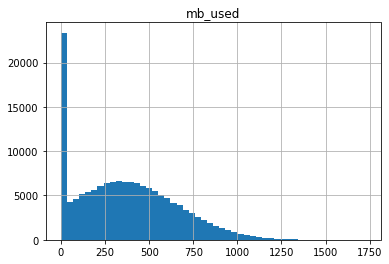

In [16]:
internet.hist('mb_used', bins=50)
plt.show()

In [17]:
print ('Количество сессий с нулем мегабайт:', len(internet.query('mb_used == 0')), 
       ', доля в общем количестве:', round((len(internet.query('mb_used == 0'))/len(internet['mb_used'])), 2))

Количество сессий с нулем мегабайт: 19598 , доля в общем количестве: 0.13


Также как и с минутами, "Мегалайн" округляет вверх значения Мб.

Доля выходов в интернет с нулевым трафиком в Мб - 13 % от общего количества. Так же, как с минутами, в реальных условяих стоило бы уточнить у оператора, как он поступает с трафиком, меньше 1 Мб, округляет до 1 Мб или же нет. 

В нашей ситуации предположим, что всё, что меньше 1 Мб не округляется в бОльшую сторону и остается нулями. Так же удалим эти строки и округлим остальные значения до целых значений.

Также заменим индекс на значения из столбца 'Unnamed: 0'

In [18]:
print('Количество строк до обработки', (internet.loc[internet.loc[:,'mb_used'] == 0]['mb_used'].count())) 
internet = internet.query('mb_used != 0')
print('Количество строк до обработки', (internet.loc[internet.loc[:,'mb_used'] == 0]['mb_used'].count())) 

Количество строк до обработки 19598
Количество строк до обработки 0


In [19]:
internet['mb_used'] = (np.ceil(internet['mb_used'])).astype(int)

In [20]:
internet.set_index('Unnamed: 0', inplace=True)

In [21]:
internet.head()

,id,mb_used,session_date,user_id
Unnamed: 0,,,,
0,1000_0,113,2018-11-25,1000
1,1000_1,1053,2018-09-07,1000
2,1000_2,1198,2018-06-25,1000
3,1000_3,551,2018-08-22,1000
4,1000_4,303,2018-09-24,1000


In [22]:
internet.duplicated().sum()

0

### messages <a id="3_3"></a>

In [23]:
messages.sample(5, random_state=42)

,id,message_date,user_id
8581,1033_332,2018-11-08,1033
12476,1054_32,2018-08-10,1054
14805,1065_141,2018-05-29,1065
118278,1481_49,2018-05-24,1481
23803,1099_10,2018-08-24,1099


In [24]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [25]:
messages.duplicated().sum()

0

### tariffs <a id="3_4"></a>

In [26]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [27]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


### users <a id="3_5"></a>

In [28]:
users.sample(5, random_state=42)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
361,1361,38,NaN,Екатеринбург,Рената,Кошелева,2018-09-09,ultra
73,1073,63,NaN,Владикавказ,Гордей,Павловский,2018-10-04,smart
374,1374,67,NaN,Махачкала,Леонид,Аркадьев,2018-04-01,smart
155,1155,71,NaN,Ставрополь,Александр,Чернов,2018-01-02,smart
104,1104,60,NaN,Нижний Тагил,Габриэль,Поляков,2018-02-21,ultra


In [29]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [30]:
users.duplicated().sum()

0

Пропуски в `churn_date` заполнять не будем. Но при создании общей таблицы учтем факт того, что часть пользователей "ушла".

Создадим словарь с id, фамилиями и именами пользователей, и оставим с основной таблице только id, чтобы не утяжелять данные с которыми мы будем работать. 

In [31]:
users_dict = users[['user_id', 'first_name', 'last_name']].drop_duplicates().reset_index(drop=True)
users = users[['user_id', 'age', 'reg_date', 'churn_date', 'city', 'tariff']]

### Изменение типа данных (даты) по всем таблицам <a id="3_6"></a>

Далее по всем таблицам приведем столбцы с датами к типу `datetime` и выделим месяца.

In [32]:
#функция для изменения типа данных на datetime и добавление столбца: год-месяц
def date_replace(list_of_tab):
    for tab in list_of_tab:
        for column in tab.columns:
            if 'date' in column and column != 'churn_date':
                try:
                    tab[column] = pd.to_datetime(tab[column], format='%Y-%m-%d')
                    tab['year_month'] = tab[column].dt.to_period('M')
                except:
                    'проверьте формат даты'
                
            if column == 'churn_date':
                try:
                    tab[column] = pd.to_datetime(tab[column], format='%Y-%m-%d')
                    tab['churn_date'] = tab[column].dt.to_period('M')
                except:
                    'проверьте формат даты'   
                
           

In [33]:
date_replace([calls, internet, messages, users])

In [34]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162994 entries, 2 to 202606
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id          162994 non-null  object        
 1   call_date   162994 non-null  datetime64[ns]
 2   duration    162994 non-null  int32         
 3   user_id     162994 non-null  int64         
 4   year_month  162994 non-null  period[M]     
dtypes: datetime64[ns](1), int32(1), int64(1), object(1), period[M](1)
memory usage: 6.8+ MB


Проверим за какой период у нас данные:

In [35]:
list_of_tab = [calls, internet, messages, users]

for tab in list_of_tab:
    if 'year_month' in tab.columns:
        print('период использования', tab['year_month'].min(), '-', tab['year_month'].max())


период использования 2018-01 - 2018-12
период использования 2018-01 - 2018-12
период использования 2018-01 - 2018-12
период использования 2018-01 - 2018-12


По всем видам услуг период один: январь - декабрь 2018 года. 

### Расчет месячных показателей для каждого пользователя <a id="3_7"></a>

**Создание таблицы пользователей по месяцам**

Создадим таблицу с месяцами и добавим к ней данные по пользователям. 

In [36]:
period = pd.DataFrame(pd.period_range('2018-01', '2018-12', freq='M'))
period.columns = ['month']

In [37]:
period['key'] = 1
users['key'] = 1

In [38]:
df = period.merge(users, on='key')

Проверим количество строк, которое получилось с расчетным (кол-во строк в таблице users * кол-во строк в period) и посмотри на результат объединения.

In [39]:
len(df)

6000

In [40]:
len(users)*len(period)

6000

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 0 to 5999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   month       6000 non-null   period[M]     
 1   key         6000 non-null   int64         
 2   user_id     6000 non-null   int64         
 3   age         6000 non-null   int64         
 4   reg_date    6000 non-null   datetime64[ns]
 5   churn_date  456 non-null    period[M]     
 6   city        6000 non-null   object        
 7   tariff      6000 non-null   object        
 8   year_month  6000 non-null   period[M]     
dtypes: datetime64[ns](1), int64(3), object(2), period[M](3)
memory usage: 468.8+ KB


Поменяем название столбца с месяцем подключения:

In [42]:
df.drop(['reg_date'], axis=1, inplace=True)
df.rename(columns={'year_month':'reg_month'}, inplace=True)

In [43]:
df.head()

,month,key,user_id,age,churn_date,city,tariff,reg_month
0,2018-01,1,1000,52,NaT,Краснодар,ultra,2018-05
1,2018-01,1,1001,41,NaT,Москва,smart,2018-11
2,2018-01,1,1002,59,NaT,Стерлитамак,smart,2018-06
3,2018-01,1,1003,23,NaT,Москва,ultra,2018-08
4,2018-01,1,1004,68,NaT,Новокузнецк,ultra,2018-05


Удалим строки с месяцами до месяца подключения пользователей:

In [44]:
df = df.query('month >= reg_month')

In [45]:
len(df)

3259

In [46]:
len(df.query('month > churn_date'))

43

и строки с месяцами после прекращения пользования тарифом

In [47]:
df = df.query('month <= churn_date or churn_date.isna()')

In [48]:
len(df)

3216

Посмотрим как выглядит наша таблица по определенным пользователям:

In [49]:
df.query('user_id == "1000"')

,month,key,user_id,age,churn_date,city,tariff,reg_month


In [50]:
df.query('user_id == "1251"')

,month,key,user_id,age,churn_date,city,tariff,reg_month


**Группировка таблиц с видами услуг по пользователям и месяцам**

Сгруппируем таблицы по пользователям и месяцам, что позволит нам объединить данные в одну таблицу и посчитать кол-во сделанных звонков, израсходованных минут, отправленных сообщений и объем израсходованного интернет-трафика по месяцам.

In [51]:
calls_pt = calls.pivot_table(index=['user_id', 'year_month'], values='duration', aggfunc = ['sum', 'count']).reset_index()
calls_pt.columns = ['user_id', 'month', 'min_per_month', 'count_calls_per_month']

print('Сумма по группируемому столбцу ДО группировки', calls['duration'].sum())
print('Сумма по группируемому столбцу ПОСЛЕ группировки', calls_pt['min_per_month'].sum())

Сумма по группируемому столбцу ДО группировки 1450301
Сумма по группируемому столбцу ПОСЛЕ группировки 1450301


Повторим тоже самое для смс и интернета. 

In [52]:
messages_pt = messages.pivot_table(index=['user_id', 'year_month'], values='id', aggfunc='count').reset_index()
messages_pt.columns = ['user_id', 'month', 'sms_per_month']

print('Сумма по группируемому столбцу ДО группировки', messages['id'].count())
print('Сумма по группируемому столбцу ПОСЛЕ группировки', messages_pt['sms_per_month'].sum())

Сумма по группируемому столбцу ДО группировки 123036
Сумма по группируемому столбцу ПОСЛЕ группировки 123036


In [53]:
internet_pt = internet.pivot_table(index=['user_id', 'year_month'], values='mb_used', aggfunc='sum').reset_index()
internet_pt.columns = ['user_id', 'month', 'mb_per_month']

print('Сумма по группируемому столбцу ДО группировки', internet['mb_used'].sum())
print('Сумма по группируемому столбцу ПОСЛЕ группировки', internet_pt['mb_per_month'].sum())

Сумма по группируемому столбцу ДО группировки 55369459
Сумма по группируемому столбцу ПОСЛЕ группировки 55369459


**Объединение таблиц с видами услуг по пользователям и месяцам**

Объединяем сгруппированные таблицы по звонкам, смс и трафику в интернете.

In [54]:
df = df.merge(calls_pt, on=['user_id', 'month'], how='left')

print('Сумма ДО', calls_pt['min_per_month'].sum())
print('Сумма ПОСЛЕ', df['min_per_month'].sum())

Сумма ДО 1450301
Сумма ПОСЛЕ 1450301.0


In [55]:
df = df.merge(messages_pt, on=['user_id', 'month'], how='left')

print('Сумма ДО', messages_pt['sms_per_month'].sum())
print('Сумма ПОСЛЕ', df['sms_per_month'].sum())

Сумма ДО 123036
Сумма ПОСЛЕ 123036.0


In [56]:
df = df.merge(internet_pt, on=['user_id', 'month'], how='left')

print('Сумма ДО', internet_pt['mb_per_month'].sum())
print('Сумма ПОСЛЕ', df['mb_per_month'].sum())

Сумма ДО 55369459
Сумма ПОСЛЕ 55369459.0


Посмотрим на результат объединения: 

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype    
---  ------                 --------------  -----    
 0   month                  3216 non-null   period[M]
 1   key                    3216 non-null   int64    
 2   user_id                3216 non-null   int64    
 3   age                    3216 non-null   int64    
 4   churn_date             189 non-null    period[M]
 5   city                   3216 non-null   object   
 6   tariff                 3216 non-null   object   
 7   reg_month              3216 non-null   period[M]
 8   min_per_month          3168 non-null   float64  
 9   count_calls_per_month  3168 non-null   float64  
 10  sms_per_month          2717 non-null   float64  
 11  mb_per_month           3201 non-null   float64  
dtypes: float64(4), int64(3), object(2), period[M](3)
memory usage: 326.6+ KB


In [58]:
df.query('user_id == "1251"')

,month,key,user_id,age,churn_date,city,tariff,reg_month,min_per_month,count_calls_per_month,sms_per_month,mb_per_month


Проверим есть ли строки, где нет данных по минутам, смс и трафику

In [59]:
df.query('min_per_month.isna() and sms_per_month.isna() and mb_per_month.isna()')

,month,key,user_id,age,churn_date,city,tariff,reg_month,min_per_month,count_calls_per_month,sms_per_month,mb_per_month
2860,2018-12,1,1128,51,2018-12,Волжский,ultra,2018-12,NaN,NaN,NaN,NaN
3090,2018-12,1,1371,50,2018-12,Омск,smart,2018-12,NaN,NaN,NaN,NaN


Удалять данные строки не будем, т.к. абонентская плата по тарифу за месяц подключения всё равно должна была быть начислена. 

### Расчет месячной выручки с каждого пользователя <a id="3_8"></a>

Добавим данные по тарифам.

In [60]:
df = df.merge(tariffs, left_on='tariff', right_on='tariff_name', how='outer')

In [61]:
df.head()

,month,key,user_id,age,churn_date,city,tariff,reg_month,min_per_month,count_calls_per_month,sms_per_month,mb_per_month,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,2018-01,1,1005,67,NaT,Набережные Челны,smart,2018-01,95.0,11.0,7.0,2730.0,50,15360,500,550,200,3,3,smart
1,2018-01,1,1032,31,NaT,Ульяновск,smart,2018-01,380.0,44.0,38.0,24147.0,50,15360,500,550,200,3,3,smart
2,2018-01,1,1045,48,NaT,Улан-Удэ,smart,2018-01,9.0,1.0,5.0,2348.0,50,15360,500,550,200,3,3,smart
3,2018-01,1,1055,39,NaT,Казань,smart,2018-01,551.0,47.0,30.0,17111.0,50,15360,500,550,200,3,3,smart
4,2018-01,1,1071,20,2018-08,Омск,smart,2018-01,194.0,18.0,16.0,15622.0,50,15360,500,550,200,3,3,smart


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype    
---  ------                 --------------  -----    
 0   month                  3216 non-null   period[M]
 1   key                    3216 non-null   int64    
 2   user_id                3216 non-null   int64    
 3   age                    3216 non-null   int64    
 4   churn_date             189 non-null    period[M]
 5   city                   3216 non-null   object   
 6   tariff                 3216 non-null   object   
 7   reg_month              3216 non-null   period[M]
 8   min_per_month          3168 non-null   float64  
 9   count_calls_per_month  3168 non-null   float64  
 10  sms_per_month          2717 non-null   float64  
 11  mb_per_month           3201 non-null   float64  
 12  messages_included      3216 non-null   int64    
 13  mb_per_month_included  3216 non-null   int64    
 14  minutes_included       3

В результате объединения таблиц появились дублирующиеся столбцы, которые не нужны нам для анализа и пропуски в столбцах с данными о потраченных минутах, Мб и смс. Пропуски появились обосновано и ожидаемо, не все абоненты используют все три способа связи, поэтому заменим NaN'ы на нули.
Так же приведем типа данных к подходящему виду.

In [63]:
#удаление лишних столбцов
df.drop('tariff_name', axis=1, inplace=True)

In [64]:
#заполнение пропусков
df[['min_per_month', 'count_calls_per_month', 'sms_per_month', 'mb_per_month']] = (
    df[['min_per_month', 'count_calls_per_month', 'sms_per_month', 'mb_per_month']].fillna(0))

In [65]:
#float to int
df['min_per_month'] = df['min_per_month'].astype('int')
df['count_calls_per_month'] = df['count_calls_per_month'].astype('int')
df['sms_per_month'] = df['sms_per_month'].astype('int')
df['mb_per_month'] = df['mb_per_month'].astype('int')

Рассчитаем помесячную выручку с каждого пользователя (вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану).

In [66]:
#фунция для расчета выручки

def billing(row):
    rub_monthly_fee = row['rub_monthly_fee']
    min_per_month = row['min_per_month']
    minutes_included = row['minutes_included']
    rub_per_minute = row['rub_per_minute']
    sms_per_month = row['sms_per_month']
    messages_included = row['messages_included']
    rub_per_message = row['rub_per_message']
    mb_per_month = row['mb_per_month']
    mb_per_month_included = row['mb_per_month_included']
    rub_per_gb = row['rub_per_gb']
        
    cost = rub_monthly_fee 
        
    #minutes
    if (min_per_month - minutes_included)> 0:
        cost += (min_per_month - minutes_included) * rub_per_minute 
    else:
        cost += 0
    
    #messages
    if (sms_per_month - messages_included) > 0:
        cost += (sms_per_month - messages_included) * rub_per_message
    else:
        cost += 0
        
    #traffic
    if (mb_per_month - mb_per_month_included) > 0:
        cost += (np.ceil(((mb_per_month - mb_per_month_included)/1024) * rub_per_gb))
    else:
        cost += 0     
        
    return cost

In [67]:
df['billing_cost'] = df.apply(billing, axis=1)

In [68]:
df.head()

,month,key,user_id,age,churn_date,city,tariff,reg_month,min_per_month,count_calls_per_month,sms_per_month,mb_per_month,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,billing_cost
0,2018-01,1,1005,67,NaT,Набережные Челны,smart,2018-01,95,11,7,2730,50,15360,500,550,200,3,3,550.0
1,2018-01,1,1032,31,NaT,Ульяновск,smart,2018-01,380,44,38,24147,50,15360,500,550,200,3,3,2267.0
2,2018-01,1,1045,48,NaT,Улан-Удэ,smart,2018-01,9,1,5,2348,50,15360,500,550,200,3,3,550.0
3,2018-01,1,1055,39,NaT,Казань,smart,2018-01,551,47,30,17111,50,15360,500,550,200,3,3,1045.0
4,2018-01,1,1071,20,2018-08,Омск,smart,2018-01,194,18,16,15622,50,15360,500,550,200,3,3,602.0


In [69]:
total_billing = df.pivot_table(index='tariff', values='billing_cost', aggfunc='sum')

total_billing['%%'] = total_billing['billing_cost'] / total_billing['billing_cost'].sum()

display(total_billing)

,billing_cost,%%
tariff,,
smart,2750336.0,0.575146
ultra,2031640.0,0.424854


Общая выручка составила почти 4,8 млн. рублей, причем бОльшая часть 2,75 млн. (57 %) приходится на тариф Смарт. 

In [70]:
print('Количество пользователей "Смарт":', users.loc[users.loc[:, 'tariff'] == 'smart']['user_id'].count())
print('Количество пользователей "Ультра":', users.loc[users.loc[:, 'tariff'] == 'ultra']['user_id'].count())

Количество пользователей "Смарт": 351
Количество пользователей "Ультра": 149


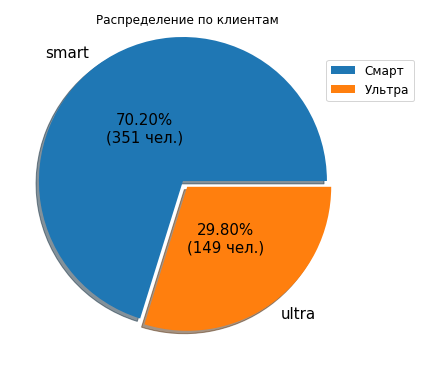

In [71]:
# количество всех клиентов для отрисовки абсолютных величин
all_users = users['user_id'].count()


def func_pct(pct):
    value = float(pct/100.*all_users)
    return "{:.2f}%\n({:.0f} чел.)".format(pct, value)

explode = (0.05, 0)  # сектор 'ultra' немного выдвинем

axes = users.groupby('tariff')['user_id'].count().plot(kind='pie', subplots=True, fontsize=15,
                                                       use_index=False, shadow=True, explode=explode,
                                                       title = 'Распределение по клиентам', pctdistance=0.45,
                                                       figsize=(16,5), autopct=lambda pct: func_pct(pct))

plt.tight_layout(pad=0)

for ax in axes:
    ax.legend(['Смарт', 'Ультра'], bbox_to_anchor=(0.87,0.87), prop={'size':12})
    ax.set_ylabel('')

## Анализ данных <a id="4"></a>

Посчитаем сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц. Найдем среднее количество, дисперсию и стандартное отклонение для каждого показателя.

In [72]:
dict_smart={'min_per_month':500, 'sms_per_month':50, 'mb_per_month':15360, 'billing_cost':550}

dict_ultra={'min_per_month':3000, 'sms_per_month':1000, 'mb_per_month':30720, 'billing_cost':1950}

In [73]:
def stat_and_plot(column, title_plot, title_hist):
    display(df.pivot_table(index='tariff', 
               aggfunc={column: [np.median, np.mean, np.var, np.std]}).round(2))
    
    #кол-во услуг по месяцам
    ax = (df.query('tariff == "ultra"').pivot_table(index='month', values=column, aggfunc='mean')
          .plot(y=column, kind='bar', grid=True, figsize=(15, 9), title=title_plot, color='orange'))
    (df.query('tariff == "smart"').pivot_table(index='month', values=column, aggfunc='mean')
     .plot(ax=ax, kind='bar', grid=True,  figsize=(15, 9), color='green'))
    plt.axhline(y=dict_ultra[column], linewidth=3, color='orange', linestyle='--' )
    plt.axhline(y=dict_smart[column], linewidth=3, color='green', linestyle='--' )
    plt.plot()
    plt.legend(['included in ultra', 'included in smart', 'ultra', 'smart'])
    plt.ylabel('quantity, unit')
    plt.show()    
    
    #гистограмма
    ax = (df.query('tariff == "ultra"')
          .plot(y=column, kind='hist', bins=50, grid=True, figsize=(15, 9), title=title_hist, color='orange', 
                histtype='step', linewidth=3))
    (df.query('tariff == "smart"')
     .plot(ax=ax, y=column, kind='hist', bins=50, grid=True,  figsize=(15, 9), color='green', 
           histtype='step', linewidth=3))
    plt.axvline(x=(df.loc[df.loc[:, 'tariff'] == 'ultra'][column].median()), 
                linewidth=3, color='orange', linestyle='--' )
    plt.axvline(x=(df.loc[df.loc[:, 'tariff'] == 'smart'][column].median()), 
                linewidth=3, color='green', linestyle='--' )
    plt.plot()
    plt.legend(['median ultra', 'median smart', 'ultra', 'smart'])
    plt.ylabel('quantity, unit')
    plt.show() 

###  Минуты <a id="4_1"></a>

min_per_month                          
                mean median     std        var
tariff                                        
smart         417.75  421.5  190.48   36281.39
ultra         526.09  518.0  317.89  101052.49

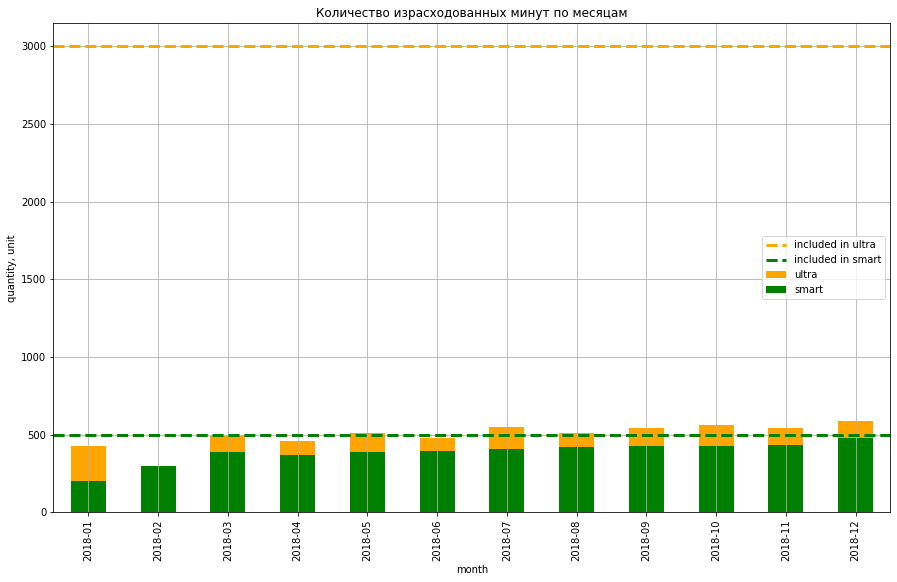

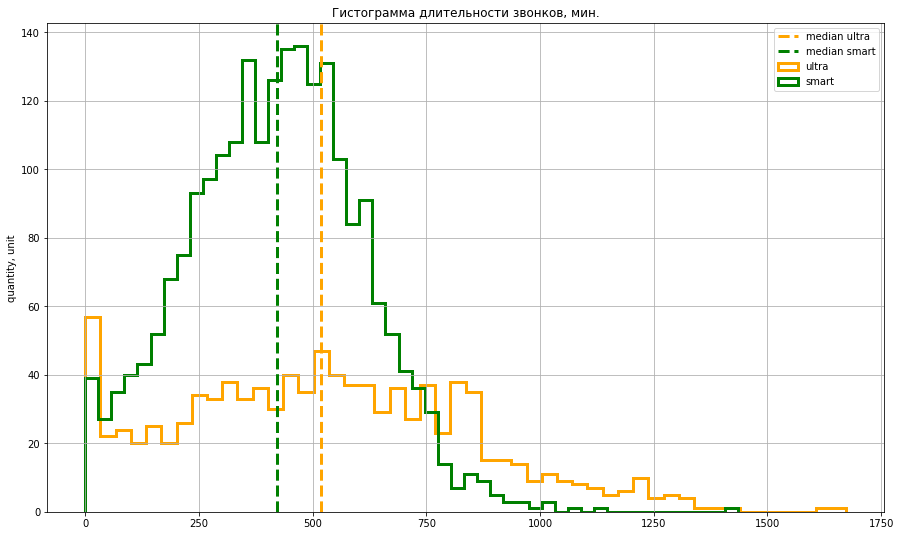

In [74]:
stat_and_plot('min_per_month', 'Количество израсходованных минут по месяцам', 
              'Гистограмма длительности звонков, мин.')

Пользователи не превышают отведенные им лимиты в рамках тарифов. 
Стоит отметить, что пользователи тарифа "Ультра" в среднем разговаривают немного больше, чем пользователи "Смарт", но и те, и другие в основном "проговоривают" примерно по 400-550 минут в месяц (медиана "Смарт" - 421 минута, медиана "Ультра" - 518 минут). 
По гистограмме мы видим, что распределение по обоим тарифам стремится к нормальному (что подтверждается расчетами: медиана и среднее почти равны).

### СМС <a id="4_2"></a>

sms_per_month                       
                mean median    std      var
tariff                                     
smart          33.37   28.0  28.23   796.96
ultra          49.31   38.0  47.81  2285.42

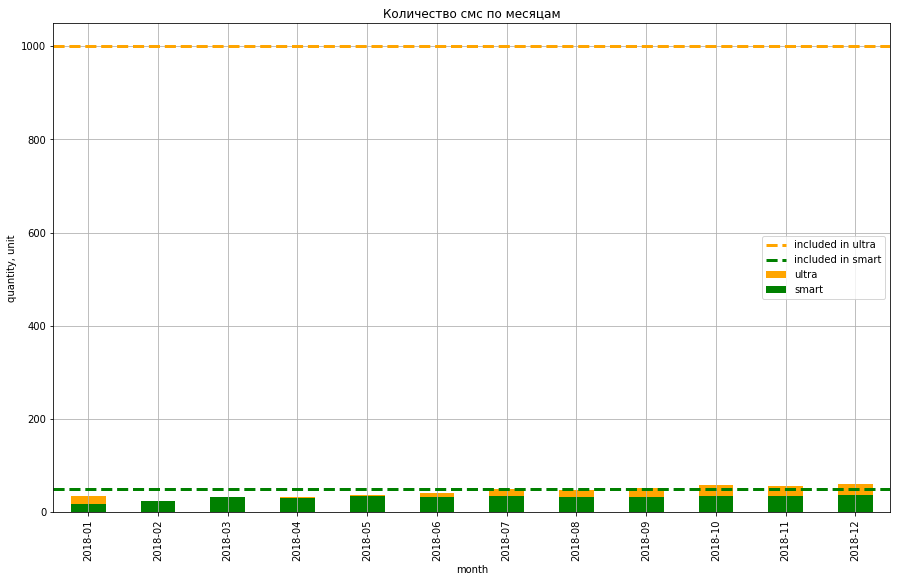

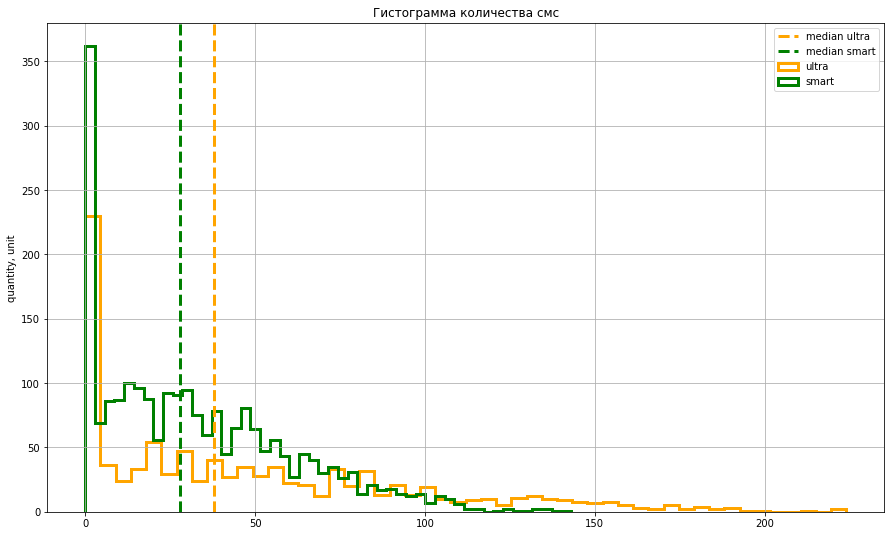

In [75]:
stat_and_plot('sms_per_month', 'Количество смс по месяцам', 
              'Гистограмма количества смс')

Как и со звонками, среднее значение по месяцам находится в районе лимита для "Смарта". 
По гистограмме можно отметить, что несмотря на общую не популярность смс-ок, активнее их используют владельцы "Смарта".


### Интернет <a id="4_2"></a>

mb_per_month                                 
               mean   median       std           var
tariff                                              
smart      16221.91  16529.0   5886.30  3.464852e+07
ultra      19467.14  19320.0  10110.26  1.022173e+08

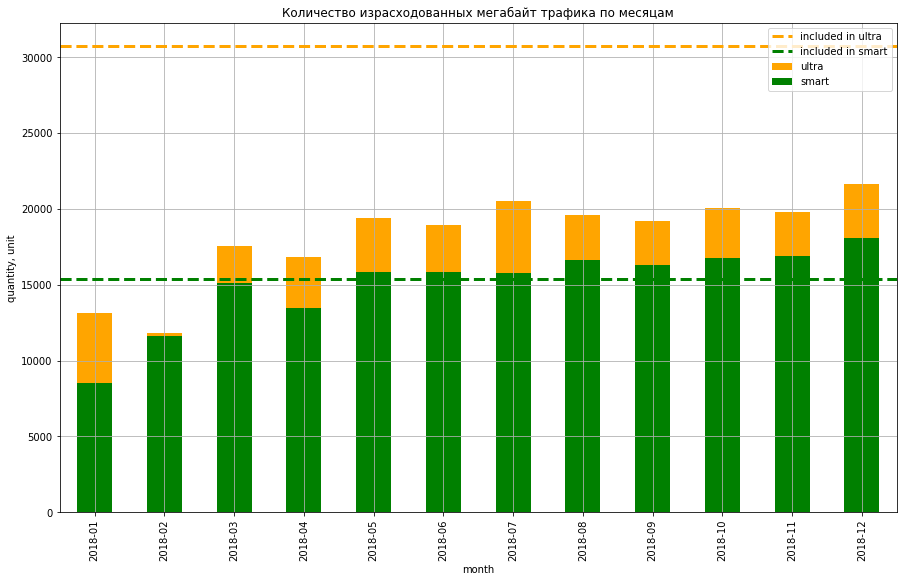

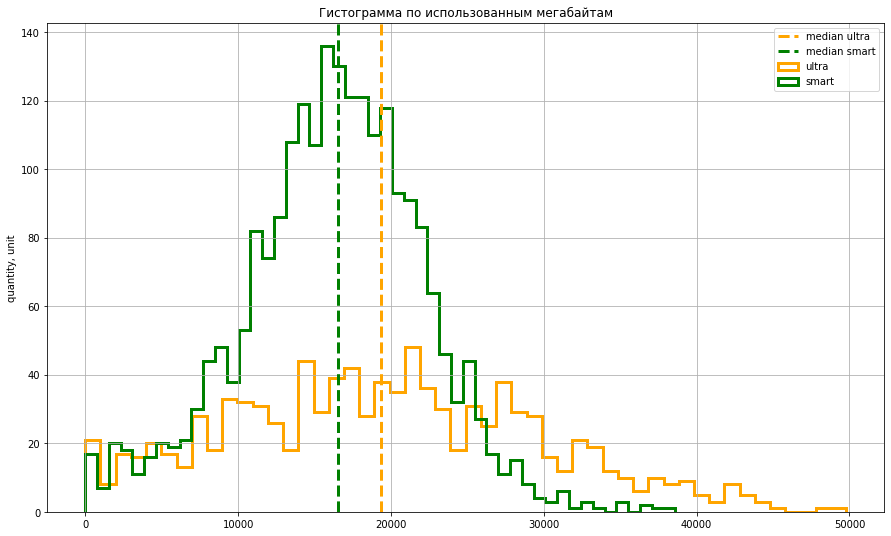

In [76]:
stat_and_plot('mb_per_month', 'Количество израсходованных мегабайт трафика по месяцам', 
              'Гистограмма по использованным мегабайтам')

Все пользователи активно используют интернет, тратят примерно от 15 до 20 Гб независимо от тарифа. 

Пользователи "Смарта" почти всегда выходят за рамки лимита в 15 Гб. Это видно и по среднему трафику за месяц и по гистограмме. 

Пользователи "Ультры" тоже иногда превышают свой лимит в 30 Гб, но таких пользователей не так много. Медианное значение в 19 Гб показывает, что чаще лимит остается неизрасходованным почти на 1/3.

## Проверка гипотез <a id="5"></a>

### средняя выручка пользователей тарифов «Ультра» и «Смарт»  <a id="5_1"></a>

Нужно проверить различается ли средняя выручка пользователей тарифов. Сформулируем гипотезы так, чтобы использовать знак равенства.  

**Нулевая гипотеза**: средняя выручка пользователей тарифов равна.

**Альтернативная гипотеза**: средняя выручка пользователей тарифов не равна.

In [77]:
ultra = df.loc[df.loc[:, 'tariff'] == 'ultra']['billing_cost']
smart = df.loc[df.loc[:, 'tariff'] == 'smart']['billing_cost']

print('Количество наблюдений для тарифа "Ультра":', len(ultra))
print('Количество наблюдений для тарифа "Смарт":', len(smart))

Количество наблюдений для тарифа "Ультра": 986
Количество наблюдений для тарифа "Смарт": 2230


Так как у нас достаточно много наблюдений, вид распределения не имеет критичного значения, для проверки гипотезы о равенстве среднего применим t-тест. 
Для определения какое значение передать для параметра equal_var рассчитаем дисперсии наших совокупностей. 

In [78]:
print('Дисперсия выручки по тарифу "Ультра":', np.var(ultra, ddof=1))
print('Дисперсия выручки по тарифу "Смарт":', np.var(smart, ddof=1))

Дисперсия выручки по тарифу "Ультра": 126944.04094274151
Дисперсия выручки по тарифу "Смарт": 620630.8490090873


Дисперсии не равны, поэтому передадим параметру `equal_var` значение False.

In [79]:
alpha = 0.05
results = st.ttest_ind(ultra, smart, equal_var=False)
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 6.654511917309927e-296
Отвергаем нулевую гипотезу


Средняя выручка пользователей тарифов не равна. 
Раз уж у нас есть функция для графиков и статистических значений, посмотрим что получается: 

billing_cost                           
               mean  median     std        var
tariff                                        
smart       1233.33   960.0  787.80  620630.85
ultra       2060.49  1950.0  356.29  126944.04

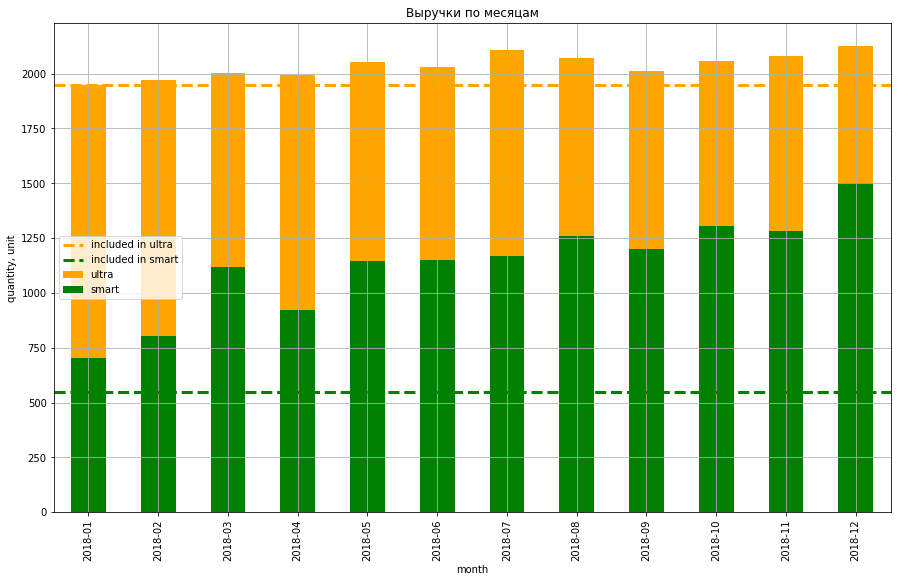

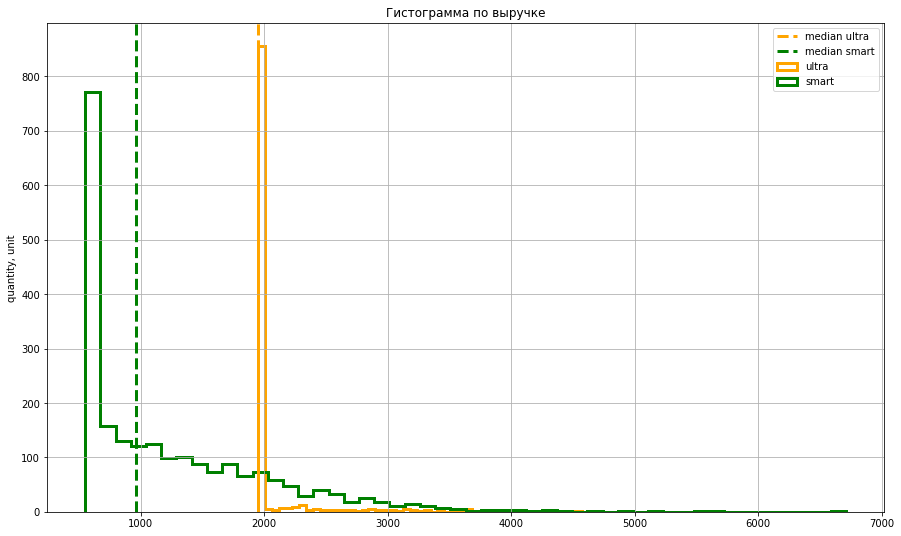

In [80]:
stat_and_plot('billing_cost', 'Выручки по месяцам', 'Гистограмма по выручке')

По графикам так же видно, что средняя выручка по тарифам не равна. Средняя выручка для "Смарта" - 1200 руб., для "Ультры" - около 2050 руб.
Средняя выручка от "Ультры" в течение года примерно одинаковая, а вот средняя выручка с пользователя от "Смарта" к концу года значительно выросла (с 700 руб. в январе до 1500 руб. в декабре). 
По гистограмме мы также видим, что пользователи "Смарта" активнее тратят деньги сверх абонентской платы. Медианное значение близко к 1000 руб., при аб.плате 550 руб. 
Пользователи "Ультры" не так часто расходуют деньги сверх аб.платы. Медиана равна стоимости аб.платы (1950 руб.)

### средняя выручка пользователей из Москвы и регионов <a id="5_2"></a>

**Нулевая гипотеза**: средняя выручка пользователей из Москвы равна выручке пользователей из других регионов.

**Альтернативная гипотеза**: средняя выручка пользователей из Москвы не равна выручке пользователей из других регионов.

In [81]:
df['city'].unique()

array(['Набережные Челны', 'Ульяновск', 'Улан-Удэ', 'Казань', 'Омск',
       'Чита', 'Красноярск', 'Архангельск', 'Ставрополь', 'Волгоград',
       'Санкт-Петербург', 'Тамбов', 'Москва', 'Киров', 'Ростов-на-Дону',
       'Уфа', 'Вологда', 'Пенза', 'Магнитогорск', 'Иркутск', 'Орёл',
       'Астрахань', 'Подольск', 'Ярославль', 'Новокузнецк', 'Самара',
       'Пермь', 'Краснодар', 'Новороссийск', 'Калининград', 'Саранск',
       'Якутск', 'Новосибирск', 'Томск', 'Саратов', 'Челябинск',
       'Петрозаводск', 'Тюмень', 'Курск', 'Сочи', 'Нижний Новгород',
       'Смоленск', 'Балашиха', 'Хабаровск', 'Махачкала', 'Ижевск',
       'Чебоксары', 'Рязань', 'Белгород', 'Мурманск', 'Воронеж',
       'Череповец', 'Владимир', 'Стерлитамак', 'Волжский', 'Калуга',
       'Екатеринбург', 'Владивосток', 'Севастополь', 'Грозный',
       'Тольятти', 'Владикавказ', 'Тула', 'Химки', 'Тверь',
       'Нижний Тагил', 'Липецк', 'Кострома', 'Барнаул', 'Оренбург',
       'Курган', 'Кемерово', 'Брянск', 'Нижневарт

In [82]:
msk_city = df.loc[df.loc[:, 'city'] == 'Москва']['billing_cost']
other_city = df.loc[df.loc[:, 'city'] != 'Москва']['billing_cost']

print('Количество наблюдений для пользователей из Москвы:', len(msk_city))
print('Количество наблюдений для пользователей из регионов:', len(other_city))

Количество наблюдений для пользователей из Москвы: 611
Количество наблюдений для пользователей из регионов: 2605


Так как у нас достаточно много наблюдений, вид распределения не имеет критичного значения, для проверки гипотезы о равенстве среднего применим t-тест. 
Для определения какое значение передать для параметра `equal_var` рассчитаем дисперсии наших совокупностей. 

In [83]:
print('Дисперсия выручки для пользователей из Москвы:', np.var(msk_city, ddof=1))
print('Дисперсия выручки для пользователей из регионов:', np.var(other_city, ddof=1))

Дисперсия выручки для пользователей из Москвы: 547324.220605833
Дисперсия выручки для пользователей из регионов: 630573.8774267257


Дисперсии не равны, поэтому передадим параметру equal_var значение False.

In [84]:
alpha = 0.05
results = st.ttest_ind(msk_city, other_city, equal_var=False)
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.4521716010094219
Не получилось отвергнуть нулевую гипотезу


In [85]:
print('Выручка пользователей из Москвы:', msk_city.mean())
print('Выручка пользователей из регионов:', other_city.mean())

Выручка пользователей из Москвы: 1507.4828150572832
Выручка пользователей из регионов: 1482.1128598848368


Выручка пользователей из Москвы равна выручке пользователей из других регионов. Разница в 100 руб. не является статистически значимой для нас.

### средняя выручка пользователей из Москвы и регионов для тарифа "Ультра" <a id="5_3"></a>

Рассмотрим дополнительные гипотезы: равна ли выручка по тарифам для пользователей Москвы и регионов.

гипотеза для "Ультры":

**Нулевая гипотеза**: средняя выручка пользователей из Москвы равна выручке пользователей из других регионов для тарифа "Ультра".

**Альтернативная гипотеза**: средняя выручка пользователей из Москвы не равна выручке пользователей из других регионов для тарифа "Ультра".

In [86]:
ultra_msk_city = df.loc[(df.loc[:, 'city'] == 'Москва') & (df.loc[:, 'tariff'] == 'ultra')]['billing_cost']
ultra_other_city = df.loc[(df.loc[:, 'city'] != 'Москва') & (df.loc[:, 'tariff'] == 'ultra')]['billing_cost']

print('Количество наблюдений для пользователей "Ультра" из Москвы:', len(ultra_msk_city))
print('Количество наблюдений для пользователей "Ультра" из регионов:', len(ultra_other_city))

print('Дисперсия выручки для пользователей "Ультра" из Москвы:', np.var(ultra_msk_city, ddof=1))
print('Дисперсия выручки для пользователей "Ультра" из регионов:', np.var(ultra_other_city, ddof=1))

Количество наблюдений для пользователей "Ультра" из Москвы: 225
Количество наблюдений для пользователей "Ультра" из регионов: 761
Дисперсия выручки для пользователей "Ультра" из Москвы: 109376.22075396826
Дисперсия выручки для пользователей "Ультра" из регионов: 132285.0015561242


In [87]:
alpha = 0.05
results = st.ttest_ind(ultra_msk_city, ultra_other_city, equal_var=False)
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.8714297959474109
Не получилось отвергнуть нулевую гипотезу


In [88]:
print('Выручка пользователей "Ультра" из Москвы:', ultra_msk_city.mean())
print('Выручка пользователей "Ультра" из регионов:', ultra_other_city.mean())

Выручка пользователей "Ультра" из Москвы: 2063.697777777778
Выручка пользователей "Ультра" из регионов: 2059.5374507227334


### средняя выручка пользователей из Москвы и регионов для тарифа "Смарт" <a id="5_4"></a>

гипотеза для "Смарта":

**Нулевая гипотеза**: средняя выручка пользователей из Москвы равна выручке пользователей из других регионов для тарифа "Смарт".

**Альтернативная гипотеза**: средняя выручка пользователей из Москвы не равна выручке пользователей из других регионов для тарифа "Смарт".

In [89]:
smart_msk_city = df.loc[(df.loc[:, 'city'] == 'Москва') & (df.loc[:, 'tariff'] == 'smart')]['billing_cost']
smart_other_city = df.loc[(df.loc[:, 'city'] != 'Москва') & (df.loc[:, 'tariff'] == 'smart')]['billing_cost']

print('Количество наблюдений для пользователей "Смарт" из Москвы:', len(smart_msk_city))
print('Количество наблюдений для пользователей "Смарт" из регионов:', len(smart_other_city))

print('Дисперсия выручки для пользователей "Смарт" из Москвы:', np.var(smart_msk_city, ddof=1))
print('Дисперсия выручки для пользователей "Смарт" из регионов:', np.var(smart_other_city, ddof=1))

Количество наблюдений для пользователей "Смарт" из Москвы: 386
Количество наблюдений для пользователей "Смарт" из регионов: 1844
Дисперсия выручки для пользователей "Смарт" из Москвы: 517357.61830294057
Дисперсия выручки для пользователей "Смарт" из регионов: 641906.2372817121


In [90]:
alpha = 0.05
results = st.ttest_ind(smart_msk_city, smart_other_city, equal_var=False)
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.1411066727679241
Не получилось отвергнуть нулевую гипотезу


In [91]:
print('Выручка пользователей "Ультра" из Москвы:', smart_msk_city.mean())
print('Выручка пользователей "Ультра" из регионов:', smart_other_city.mean())

Выручка пользователей "Ультра" из Москвы: 1183.2642487046633
Выручка пользователей "Ультра" из регионов: 1243.815618221258


## Общий вывод <a id="6"></a>

In [92]:
total_2 = df.pivot_table(index='tariff', 
                       aggfunc=({'min_per_month':'mean', 
                            'sms_per_month':'mean', 
                            'mb_per_month':'mean', 
                            'billing_cost':['mean', 'sum']})).round(2)

total_2['limit_mb'] = [15360, 30720]
total_2['limit_min'] = [500, 3000]
total_2['limit_sms'] = [50, 1000]

display(total_2)
print('Количество пользователей "Смарт":', users.loc[users.loc[:, 'tariff'] == 'smart']['user_id'].count())
print('Количество пользователей "Ультра":', users.loc[users.loc[:, 'tariff'] == 'ultra']['user_id'].count())

billing_cost            mb_per_month min_per_month sms_per_month  \
               mean        sum         mean          mean          mean   
tariff                                                                    
smart       1233.33  2750336.0     16221.91        417.75         33.37   
ultra       2060.49  2031640.0     19467.14        526.09         49.31   

       limit_mb limit_min limit_sms  
                                     
tariff                               
smart     15360       500        50  
ultra     30720      3000      1000

Количество пользователей "Смарт": 351
Количество пользователей "Ультра": 149


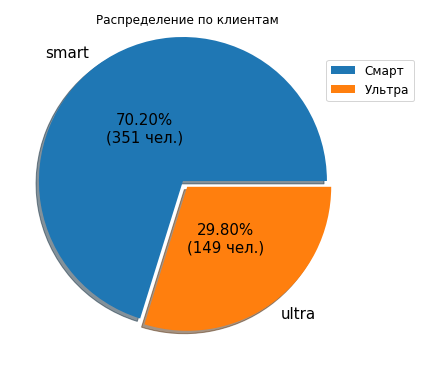

In [93]:
# количество всех клиентов для отрисовки абсолютных величин
all_users = users['user_id'].count()


def func_pct(pct):
    value = float(pct/100.*all_users)
    return "{:.2f}%\n({:.0f} чел.)".format(pct, value)

explode = (0.05, 0)  # сектор 'ultra' немного выдвинем

axes = users.groupby('tariff')['user_id'].count().plot(kind='pie', subplots=True, fontsize=15,
                                                       use_index=False, shadow=True, explode=explode,
                                                       title = 'Распределение по клиентам', pctdistance=0.45,
                                                       figsize=(16,5), autopct=lambda pct: func_pct(pct))

plt.tight_layout(pad=0)

for ax in axes:
    ax.legend(['Смарт', 'Ультра'], bbox_to_anchor=(0.87,0.87), prop={'size':12})
    ax.set_ylabel('')

По результатам анализа получается, что несмотря на то, что абонентская плата тарифа "Ультра" выше (1950 руб.), больше выручки "Мегалайну" приносит тариф "Смарт" с меньшей аб.платой (550 руб.), т.к. его абоненты вынуждены тратить деньги на дополнительные пакеты интернет-трафика. В среднем пользователи "Смарта" тратят больше 16 Гб при лимите в 15. 

При этом стоит отметить, что количество израсходованных минут и отправленных смс на обоих тарифах не сильно отличается и колеблется +/- в рамках лимита по тарифу "Смарт": среднее кол-во потрачнных минут 417 и 526 и 33 и 49 смс для "Смарта" и "Ультры" соответственно при лимите для "Смарта" 500 минут и 50 смс. Т.е. пользователи "Ультры" чаще всего не доиспользуют услуги в рамках своего пакета в части звонков и смс. Можно сделать предположение, что "Ультру" выбирают только из-за большого пакета интернет-трафика. 

Нельзя однозначно ответить какой для "Мегалайна" лучше тариф, т.к. "Смарт" дает бОльшую выручку при меньшем потреблении ресурсов, но и при бОльшем же количестве пользователей. Выручка за год по "Смарту" составила 2,7 млн. от 351 пользователя, по "Ультре" - 2 млн. от 149 пользователей. Если "Мегалайн" сделает ставку только на "Смарт", то придется тратиться на привлечение бОльшего количества клиентов, т.е. возможно нужна будет более агрессивная и заметная рекламная компания, чем на текущий момент. 
Мне кажется, что оптимальным решением будет внедрить 3ий тарифный план со стоимостью и лимитами между "Смартом" и "Ультрой".   

Для пользователей, к сожалению, оба тарифа не могут удовлетворить соотношению "цена/качество", приходится или регулярно доплачивать за услуги сверх тарифа на "Смарте" или сразу платить больше на "Ультре". 
Создание третьего промежуточного тарифа в том числе решит и проблему пользователей, а также может повысить лояльность клиентов к оператору.

И в столице, и в регионах пользователи тратят на мобильную связь примерно одинаковое количество денег. Таким образом, можно сказать, что "Мегалайну" есть смысл продвигать свои тарифы по всей России. 
